In [1]:
import pandas as pd
import numpy as np
import os # To set our working folder
import re
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as mticker
import seaborn as sns
import yfinance as yf  # This gets us prices from Yahoo finance. See https://pypi.org/project/yfinance/
from pandas.tseries.offsets import MonthEnd
import statsmodels.formula.api as smf

---

### Estimating the yield curve from bon yeileds dowloaded from Datastream and Eikon ###

---

In [2]:
df = pd.read_excel("Search_1653096048350.xlsx")
df=df[['Issuer', 'ISIN', 'Amount Issued (USD)', 'price', 'Coupon', 'Maturity', 'ttm', 'YTM', 'Bond Grade']].dropna()
df.columns = df.columns.str.lower()
df = df.assign(ttm2 = df.ttm**2,
               ttm3 = df.ttm**3
              )

In [3]:
df.sample(5)

,issuer,isin,amount issued (usd),price,coupon,maturity,ttm,ytm,bond grade,ttm2,ttm3
74,Vector Ltd,NZVCTDT013C8,143122487,95.0890,3.69,2027-11-26,5.513889,4.7089,Investment Grade,30.402971,167.638602
17,Auckland International Airport Ltd,NZAIADT220L0,63609994,100.0370,3.64,2023-04-17,0.905556,3.5961,Investment Grade,0.820031,0.742584
19,ANZ Bank New Zealand Ltd,NZANBDT022C1,318049972,100.1080,3.70,2023-05-30,1.025000,3.5884,Investment Grade,1.050625,1.076891
80,Kiwi Property Group Ltd,NZKPGD0050L3,95414991,89.0700,2.85,2028-07-19,6.161111,4.9301,Investment Grade,37.959290,233.871404
45,Kiwi Property Group Ltd,NZKPGD0030L5,79512493,99.8397,4.33,2024-12-19,2.577778,4.3932,Investment Grade,6.644938,17.129174


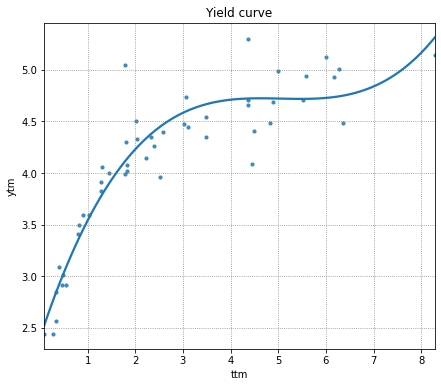

                            OLS Regression Results                            
Dep. Variable:                    ytm   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     104.9
Date:                Tue, 24 May 2022   Prob (F-statistic):           4.50e-20
Time:                        07:26:09   Log-Likelihood:                -3.5724
No. Observations:                  48   AIC:                             15.14
Df Residuals:                      44   BIC:                             22.63
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4003      0.124     19.375      0.0

In [4]:
#Scatter Plot

def set_xmargin(ax, left=0.0, right=0.3):
    ax.set_xmargin(0)
    ax.autoscale_view()
    lim = ax.get_xlim()
    delta = np.diff(lim)
    left =  lim[0] - delta*left
    right = lim[1] + delta*right
    ax.set_xlim(left,right)

def scattplot(X, Y, monthly_ret):
    results = smf.ols('ytm ~ 1 + ttm + ttm2 + ttm3', data=df).fit()
    
    fig = plt.figure(figsize=(7,6))
    ax = sns.regplot(x=X, y=Y, data=df, scatter_kws={"s": 10}, order=3, ci=None)
    
    set_xmargin(ax, left=0, right=0)
    
    # Titles and axes names
    ax.set_title(r'Yield curve')
    ax.set_xlabel(X)
    ax.set_ylabel(Y)
    plt.grid(linestyle="dotted", color='grey')
    
    # Equation
    #plusmin = '-' if results.params.Intercept<0 else '+'
    #equation = f'${{{Y}}}$ =  {results.params[1]:.3f} ${{{X}}}$ {plusmin} {abs(results.params.Intercept):.3f}'
    #ax.text(y = monthly_ret[Y].max(), x = monthly_ret[X].min(), s = equation)
    plt.show()
    print(results.summary())
    return results.params

params  = scattplot("ttm", "ytm", df)

In [5]:
params

Intercept    2.400301
ttm          1.399323
ttm2        -0.279119
ttm3         0.018427
dtype: float64

---

### Risk free rate and market premium usinf RBNZ data and the NZ50 ###

In [6]:
dfr = pd.read_excel("hb2-monthly.xlsx", skiprows=[0,2,3,4])
dfr.sample(5)

,Unnamed: 0,Official Cash Rate (OCR),Overnight interbank cash rate,30 days,60 days,90 days,1 year,2 year,5 year,10 year,15 February 2016,20 September 2025,20 September 2030,20 September 2035,20 September 2040
257,2006-06-30,7.25,7.25,7.43,7.46,7.47,6.89,6.37,5.97,5.84,3.26,NaN,NaN,NaN,NaN
172,1999-05-31,4.50,4.50,4.61,4.64,4.67,4.13,4.93,5.73,6.12,4.84,NaN,NaN,NaN,NaN
186,2000-07-31,6.50,6.50,6.67,6.78,6.83,6.77,6.78,6.74,6.73,4.79,NaN,NaN,NaN,NaN
177,1999-10-31,4.50,4.50,4.71,4.88,5.10,5.79,6.26,6.83,7.11,5.04,NaN,NaN,NaN,NaN
32,1987-09-30,NaN,18.31,19.12,19.13,19.09,18.13,17.94,16.34,15.67,NaN,NaN,NaN,NaN,NaN


In [7]:
dfr=dfr[['Unnamed: 0', '90 days', '5 year']].dropna() # https://fealty.co.nz/business-valuation-nz/#:~:text=NZ%20Treasury%20%28October%202016%29%20has%20provided%20a%20risk,risk%20premium%20of%207%25.%20Specific%20Company%20Risk%20Premium
dfr.columns = ['Date', 'rf', 'rf5']
list(dfr)
dfr["Date"]= pd.to_datetime(dfr["Date"])
dfr.set_index('Date', inplace=True)
dfr = dfr.shift(1) # Attribute April data to May, as the date can be taken as ex ante
dfr.dropna(inplace=True)
dfr.tail(5)

,rf,rf5
Date,,
2021-12-31,0.83,2.33
2022-01-31,0.91,2.21
2022-02-28,1.03,2.36
2022-03-31,1.21,2.58
2022-04-30,1.49,2.93


In [8]:
dfr /= 1200

In [9]:
dfr.head()

,rf,rf5
Date,,
1985-04-30,0.022058,0.015342
1985-05-31,0.018392,0.015558
1985-06-30,0.020208,0.016583
1985-07-31,0.019775,0.015150
1985-08-31,0.020017,0.014892


<AxesSubplot:xlabel='Date'>

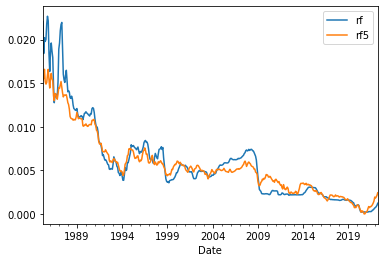

In [10]:
dfr.plot()

In [11]:
dfm = yf.download(tickers=['^NZ50'], start='1985-03-31', end='2022-04-30', interval="1mo")['Adj Close'].dropna().to_frame()
dfm.columns = ['MPrice']
dfm.index = pd.to_datetime(dfm.index, format="%Y%m") + MonthEnd(0)

[*********************100%***********************]  1 of 1 completed


In [12]:
dfm = np.log(dfm).diff().dropna()
dfm = dfm.shift(1) # Attribute April data to May, as the date can be taken as ex ante
dfm.dropna(inplace=True)

<AxesSubplot:xlabel='Date'>

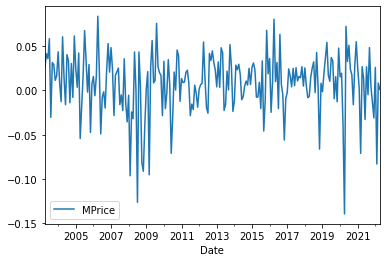

In [13]:
dfm.plot()

**Join market return and risk-free rate**

In [14]:
dfmr = dfm.join(dfr)

<AxesSubplot:xlabel='Date'>

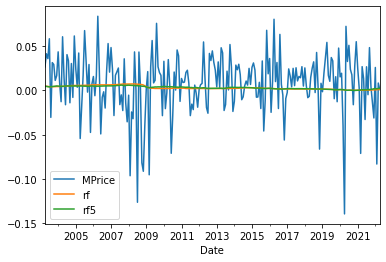

In [15]:
dfmr.plot()

In [16]:
dfmr['Market Risk premium'] = dfmr['MPrice'].sub(dfmr['rf5'])

<AxesSubplot:xlabel='Date'>

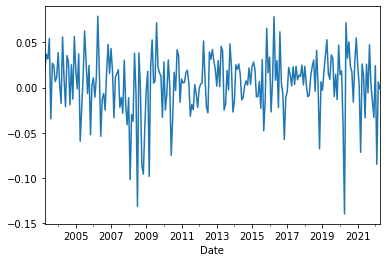

In [17]:
dfmr['Market Risk premium'].plot()

In [18]:
dfmr['Market Risk premium'].mean()*100

0.49286210414783316